In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm

platform = 'cpu'
device = torch.device(platform)
model = torchani.models.ANI1ccx()
model = model.to(device)
torch.set_num_threads(2)

In [11]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2

# specify a run number
nr_of_runs = 1
# number of time steps
nr_of_mc_trials = 500

t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)



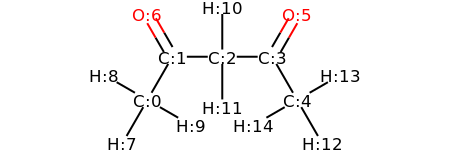

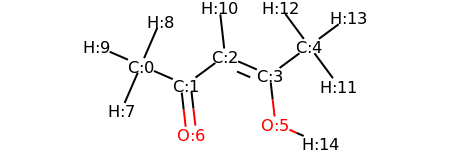

In [12]:
neutromeratio.display_mol(mols['t1'])
neutromeratio.display_mol(mols['t2'])

[utils.py:48 - get_donor_atom_idx()] Index of atom that moves: 11.
[utils.py:54 - get_donor_atom_idx()] Index of atom that donates hydrogen: 2
[utils.py:72 - get_donor_atom_idx()] Index of atom that accepts hydrogen: 5


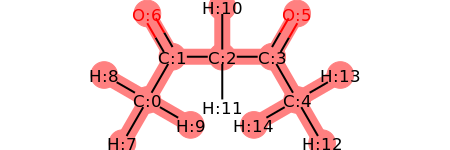

Hydrogen 11 is moved from atom-idx 2 to atom-idx 5.


In [13]:
# generating mdtraj traj object
topology = md.load(f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb").topology
tautomer_transformation = neutromeratio.get_donor_atom_idx(from_mol, to_mol)

energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['atom_list'],
                                          platform = platform,
                                          tautomer_transformation = tautomer_transformation,
                                          bond_restraint=True)

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['atom_list'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)

hydrogen_mover = neutromeratio.Instantaneous_MC_Mover(donor_idx = tautomer_transformation['donor_idx'], 
                                       hydrogen_idx = tautomer_transformation['hydrogen_idx'], 
                                       acceptor_idx = tautomer_transformation['acceptor_idx'], 
                                       atom_list = ani_input['atom_list'], 
                                       energy_function = energy_function,
                                       langevin_dynamics= langevin)



# initial conditions: coordinates from example were given in units of angstroms   
x0 = np.array(ani_input['coord_list']) * unit.angstrom

print(f"Hydrogen {hydrogen_mover.hydrogen_idx} is moved from atom-idx {hydrogen_mover.donor_idx} to atom-idx {hydrogen_mover.acceptor_idx}.")

In [14]:
# generating mdtraj traj object
topology = md.load(f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb").topology

# run MD and MC protocoll
for run in range(1, nr_of_runs+1):
    traj = hydrogen_mover.perform_md_mc_protocol(x0 = x0,
                             nr_of_mc_trials = nr_of_mc_trials)
    # save trajectory
    ani_traj = md.Trajectory(traj, topology)
    ani_traj.save(f"../data/md_mc_sampling/{name}/{name}_t{from_mol_tautomer_idx}_run{run}_anicxx.dcd")

    # save work values (overwriting after each new run)
    f = open(f"../data/md_mc_sampling/{name}/instantaenous_MC_{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_work.csv", 'w+')
    for i, j in enumerate(hydrogen_mover.work_values):
        f.write('{}, {}\n'.format(i, j))
    f.close()




  2%|▏         | 10/500 [00:27<22:03,  2.70s/it]

KeyboardInterrupt: 

In [ ]:
top_file = f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb",
traj_files = []
for run in range(1, nr_of_runs+1):
    traj_files.append(f"../data/md_mc_sampling/{name}/{name}_t{from_mol_tautomer_idx}_run{run}_anicxx.dcd")
    

In [ ]:
generate_nglview_object(
    top_file=top_file,
    traj_files=traj_files
)

In [ ]:
hydrogen_mover.write_xyz_files(1, 'test')

In [ ]:
#save work values for different hydrogen movers
for h_m in hydrogen_movers:
    mod_bond_length = h_m.acceptor_mod_bond_length
    stddev = h_m.acceptor_hydrogen_stddev_bond_length / unit.angstrom

    f = open(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_work_bond_length{mod_bond_length}_std{stddev}.csv", 'a+')
    for ts, work in enumerate(h_m.work_values):
        f.write('{}, {}\n'.format(ts, work))
    f.close()



In [ ]:
# define different hydrogen_movers
hydrogen_movers = []

for mod_bond_length in [0.8,0.9,0.95,1.0,1.05,1.1,1.2]:
    for stddev in [0.001, 0.01, 0.1, 0.15, 0.25]:
        h_m = Instantenous_MC_Mover(donor_idx = donor['donor'], 
                                       hydrogen_idx = donor['hydrogen_idx'], 
                                       acceptor_idx = acceptor, 
                                       atom_list = ani_input['atom_list'], 
                                       energy_function = energy_function)
        h_m.acceptor_mod_bond_length = mod_bond_length
        h_m.acceptor_hydrogen_stddev_bond_length = stddev * unit.angstrom
        hydrogen_movers.append(h_m)

# calculate work for the different hydrogen_movers 
use_precalculated_md_and_perform_mc(top = top_file, 
                                     trajs = traj_files, 
                                     hydrogen_movers = hydrogen_movers,
                                    mc_every_nth_frame=100)
